Non Fungible Tokens (NFTs) are one-of-a-kind digital products that contain visual and audio-based static or continuous content. 

Their uniqueness ensured by the blockchain architecture enables trading of these assets and represents new generation ownership for them.

The Art in this dataset is a collected from various NFT showrooms. The art could be any form of artistic NFT. Such as Photos, GIFs, Videos. 

The art word can be NSFW / contain sexual content. Most NSFW art pieces have been labeled as NSFW.

# installing

In [ ]:
!pip3 install tfa-nightly # for metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
!pip install split-folders # for splitting folders into train,test,validation in the format of tensorflow image data generation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip # for analysis report 

In [ ]:
# !pip install pyautogui # to prevent colab from disconnecting 
#https://github.com/bnsreenu/python_for_microscopists/blob/master/tips_tricks_32_automate_periodic_mouse_movements.py

### import packages 

In [ ]:
# for operating system commands and directory handeling 
import glob
import shutil
import os

import numpy as np #essentials 
import pandas as pd # dataframe
import seaborn as sns # visualization
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set()

#metrics and evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,precision_score,recall_score,f1_score,precision_recall_curve

# scaling and encoding 
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from time import time

#image processing
import PIL 
from keras.preprocessing.image import img_to_array ,ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions 
import matplotlib.pyplot as plt 
import numpy as np 

# deep learning models 
from keras.applications.resnet import ResNet152
from keras.applications import resnet 
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_addons as tfa #metrics
from tensorflow.keras import metrics # metrics
import tensorflow as tf



from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle

Mounted at /content/drive


# importing data from kaggle 

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vepnar/nft-art-dataset

  7% 2.13G/31.0G [00:19<04:25, 117MB/s]
User cancelled operation


In [ ]:
# !unzip /content/nft-art-dataset.zip
!unzip /content/dataset.csv.zip

Archive:  /content/dataset.csv.zip
  inflating: dataset.csv             


# read data 

In [ ]:
# All_data = pd.read_csv("/path/to/csv/dataset.csv")
All_data = pd.read_csv("/content/drive/MyDrive/da_project_data_split/dataset.csv") # path to the csv file 

# goals from this dataset :

*   **price analysis : made up prices**
*   price regression, is mostly based on creator not the art it self
*   **NSFW classification**, even though the nsfw data is not labeled carefully, we will try to make predict the NSFW lables based on the image only and the image & text associated with it 
*   NLP on art series



# domain knowledge about the data :

* tokens are how many unique copies are for sale  ?? 
* symbol : the currency 
* nsfw : if the image contains sensitive information or not (incompelete) 
* creator : name of artist
* type : there is (photos, gifs and videos) , we will work on images for simpilicity 

**key point from manual exploration:**
* from data exploration we found the art here to be very chaotic and 

* hard to understand even for humans,

* the data is not carefully labeled

* the prices are exaggerated 
 


# data integrity check :


the prices on june 2022:

source:[original website](https://nftshowroom.com/)

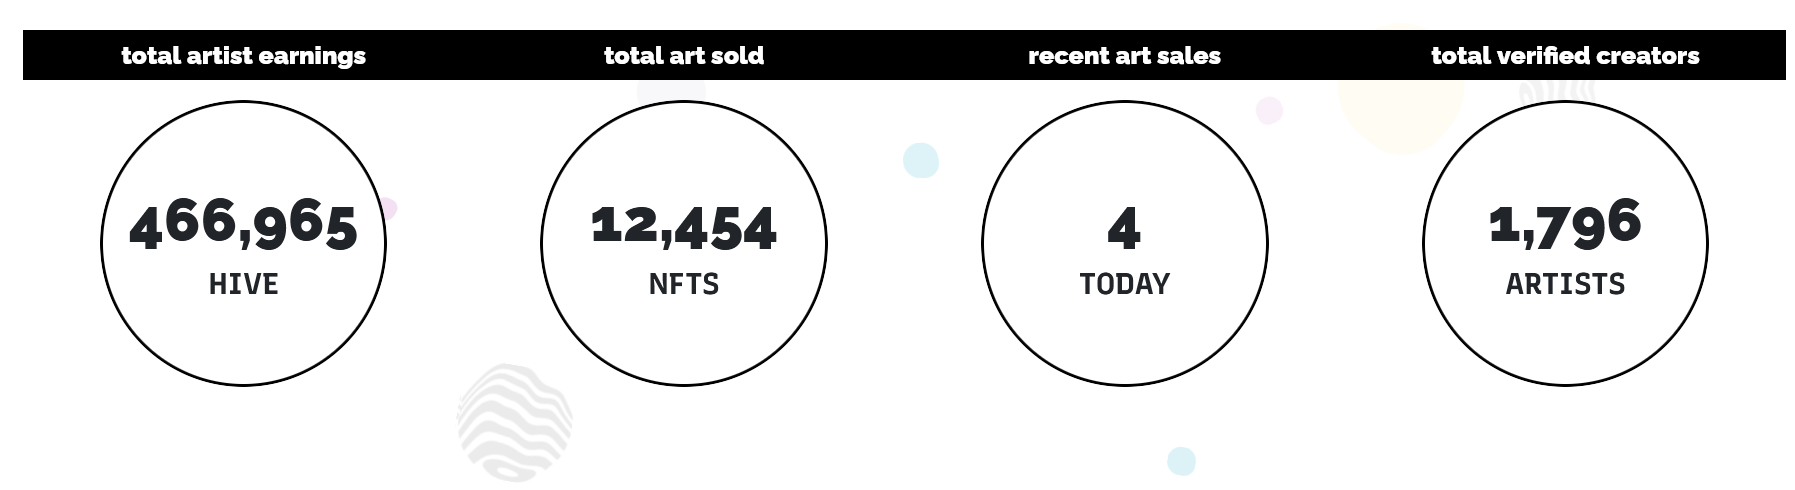

In [ ]:
print('total prices in this dataset is {0:.2f} hive '.format(All_data['price'].sum()))

total prices in this dataset is 8406916.60 hive 


as of 2021 (the time the dataset was created) the total prices of NFTs is 8.4 million hive, 

where the total earnings on the website is less than half a million, the price data is only of 




In [ ]:
len(All_data['creator'].unique()) # total unique artist

515

In [ ]:
len(All_data['title'].unique()) # total unique names of art 

1715

In [ ]:
len(All_data['art_series'].unique())

4120

there is less titles than art_series because one art series contains multiple variation of the same title 

# data splitting: 
due to problems in kaggle we switched to colab and generated a folder containing sfw images in subfolder and nsfw images in another subfolder 

this is a requirment for splitting the data in a way that make it easy to test different split ration using split-folder liberary 

## handeling nsfw folders for image data generation (tensorflow augmantaion class)
this part is only generated once and we used the new directory for our models 

In [ ]:
NSFW_img_path = All_data[(All_data["type"] == 'PHOTO')  & ( All_data["nsfw"]== True)].pop('path')

In [ ]:
NSFW_img_path # fetching all the image path of NSFW

2       ./dataset/image/QmaifAjZTJd8jTxNrwSoGWmFpbPYcs...
26      ./dataset/image/QmeddHYx6UDmTRRLDdCYmzVK4VjRGQ...
28      ./dataset/image/QmaM1zTWoiYwT5L4BNcaaRnB56ueai...
33      ./dataset/image/QmbQASW3MxD8AzDNaPCFunKJ8rVSSQ...
69      ./dataset/image/QmVyVXEKrwhTBo6QsvPqC4vSK5THwt...
                              ...                        
3843    ./dataset/image/Qmazun61wXRfPjHDwwE7pDtRSuekeH...
3880    ./dataset/image/QmVDXWPYxQ97Z9vB6hEoTbWKgzrS1g...
4096    ./dataset/image/QmQ9BRvwJyysQDuEqsGNEfcA7na93v...
4145    ./dataset/image/QmQ9BRvwJyysQDuEqsGNEfcA7na93v...
4160    ./dataset/image/QmXjhH7XLddZdssnSnj9CxYt12WRqm...
Name: path, Length: 118, dtype: object

In [ ]:
sfw_data = All_data.copy()

In [ ]:
sfw_data.drop(NSFW_img_path.index, inplace=True) # removing the nsfw photos from the sfw paths

In [ ]:
sfw_data_check = sfw_data[(sfw_data["type"] == 'PHOTO')  & ( sfw_data["nsfw"]== True)].pop('path')

In [ ]:
len(sfw_data_check) # there is no data leakage of NSFW images in the sfw_dataframe

0

#### create directory for the nsfw images


to generate your own folder path replace the paths below 

In [ ]:
newpath = r'/content/dataset/nsfw_images' # choose a new path for your directory here  
if not os.path.exists(newpath):
    os.makedirs(newpath)

src_dir = NSFW_img_path
dst_dir = newpath
for jpgfile in NSFW_img_path:
    shutil.move(jpgfile, dst_dir) # moving nsfw images from original folder to other folder

In [ ]:
# Directory 
directory = "all_data" # the path to both sub folders 
  
# Parent Directory path
parent_dir = "/content/dataset/"
  
# Path
path = os.path.join(parent_dir, directory)
os.mkdir(path)
# move the 2 folders in one folder

In [ ]:

shutil.move("/content/dataset/image", "/content/dataset/all_data")
shutil.move("/content/dataset/nsfw_images", "/content/dataset/all_data")


'/content/dataset/all_data/nsfw_images'

In [ ]:
%rm -rf '/content/dataset/video' #remove videos from the directory
%rm -rf '/content/dataset/gif'  


In [ ]:
shutil.move("/content/dataset/all_data", "//content/drive/MyDrive/da_project_data_split") 

now we have our folders ready you can find it here : [link](https://drive.google.com/drive/folders/14Na-g0GonlUDnk8UrwRiALugCBjtuNT_?usp=sharing)

this link has access to edit, please don't delete any images 

In [ ]:
analysis_data = All_data.drop(columns=['symbol','royalty','cid','path','name','art_series','title'])

# remove corrupted images :

during training we found that some of the images are too big for the model to handel and some are corrupted they doesn't contain JFIF header which tensorflow requires 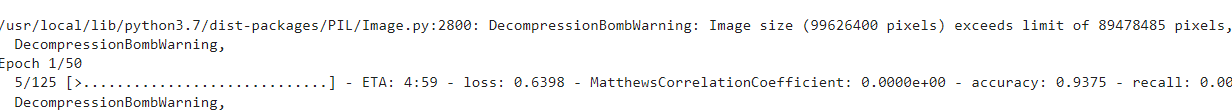

#### https://stackoverflow.com/questions/62220855/tensorflow-removing-jfif

In [ ]:
import os 
num_skipped = 0
for folder_name in ("image", "nsfw_images"):
    folder_path = os.path.join("/content/drive/MyDrive/da_project_data_split/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


#label endcoding  & outlier analysis


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
analysis_data['type'] = le.fit_transform(analysis_data['type'])

In [ ]:
analysis_data['creator']=le.fit_transform(analysis_data['creator']) 

In [ ]:
analysis_data['nsfw'] =le.fit_transform(analysis_data['nsfw'])

In [ ]:
analysis_data.head()

,creator,price,type,likes,nsfw,tokens,year,rights
0,257,50.0,1,2,0,30,2020,1
1,233,500.0,2,0,0,1,2020,1
2,58,10.0,1,0,1,2,2021,1
3,502,20.0,1,1,0,2,2020,1
4,502,20.0,0,0,0,2,2020,1


Name & art_series could be used for lstm model

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


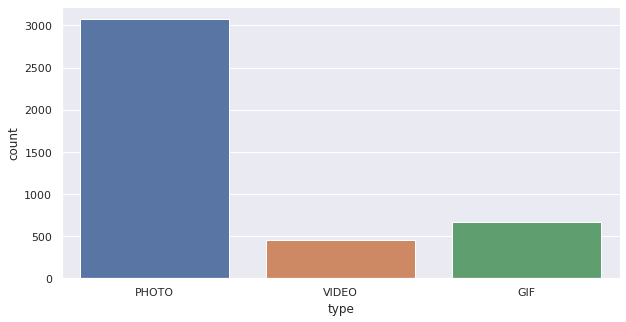

In [ ]:
#NFTs are simply a unique digital tokens that allow artists to trade their work in credible way 
plt.rcParams["figure.figsize"] = (10,5)
sns.countplot(All_data['type'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


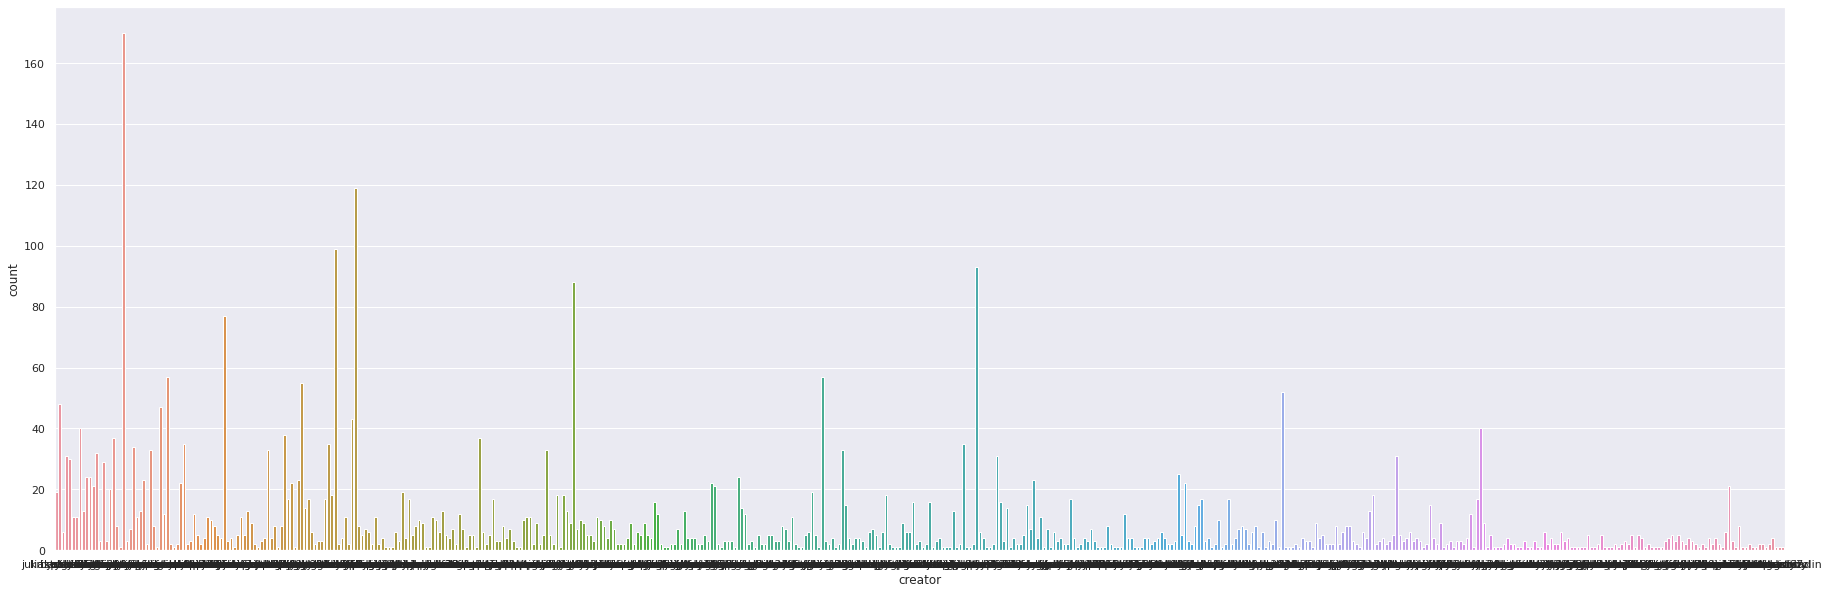

In [ ]:
plt.rcParams["figure.figsize"] = (31,10)
sns.countplot(All_data['creator'])
plt.show()

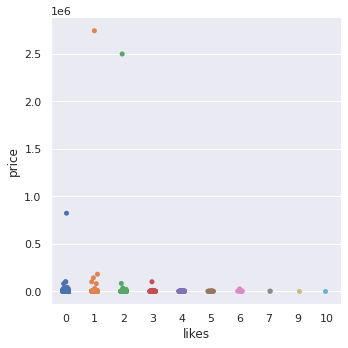

In [ ]:
sns.catplot(x='likes', y='price', data=analysis_data)


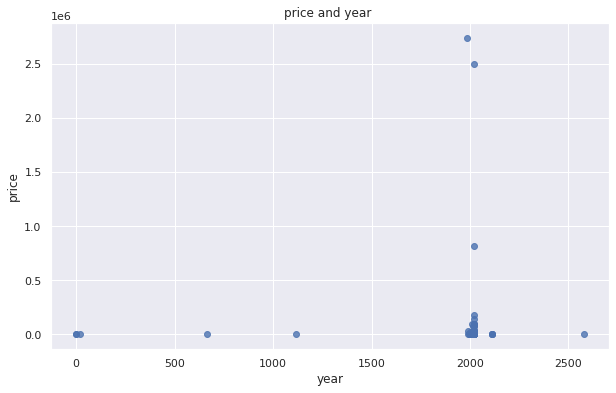

In [ ]:
# TODO write code to answer Q2.2
plt.figure(figsize=(10,6))
sns.regplot(x='year', y='price', data=analysis_data, fit_reg=False)
plt.title('price and year ')
plt.show()

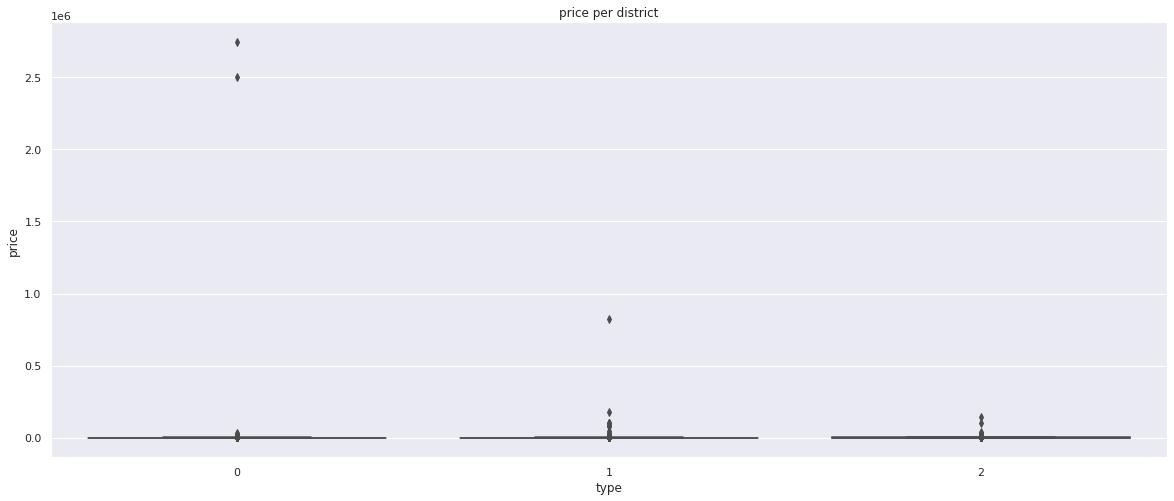

In [ ]:
plt.subplots(figsize=(20,8))
sns.boxplot(x='type', y='price', data=analysis_data)
plt.title('price per district')
plt.show()

In [ ]:
All_data.skew().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


price      42.831413
tokens     37.523305
nsfw        5.193777
likes       2.794721
rights      0.846945
royalty     0.000000
year      -30.095375
dtype: float64

In [ ]:
All_data[All_data["type"] == 'PHOTO'].groupby('creator')['creator'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(5)

,creator,count
138,elenasteem,157
48,artxmike,99
341,richardfyates,86
325,pollyfoxxy,72
34,andrianna,57


In [ ]:
All_data.head()

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
0,30 min Drawings,Giant Frog,kristyglas,kristyglas_30-min-drawings_giant-frog,50.0,SWAP.HIVE,PHOTO,2,False,30,2020,1,0,QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH,./dataset/image/QmegjZDN2gyD9A6cG4efj8DwbLLGTW...
1,Experimental Video,Biospecimens,juliakponsford,juliakponsford_experimental-video_biospecimens,500.0,SWAP.HIVE,VIDEO,0,False,1,2020,1,0,QmeN4KuTQwHPWvGDhiopNJziqmf1feGeabDD4Gk7z9DgUL,./dataset/video/QmeN4KuTQwHPWvGDhiopNJziqmf1fe...
2,Sexy Art,long legs,badsexy,badsexy_sexy-art_long-legs,10.0,SWAP.HIVE,PHOTO,0,True,2,2021,1,0,QmaifAjZTJd8jTxNrwSoGWmFpbPYcszMF4ZcZDBwpRR4v4,./dataset/image/QmaifAjZTJd8jTxNrwSoGWmFpbPYcs...
3,Dream World,A Guide in my Dreams,yoslehz,yoslehz_dream-world_a-guide-in-my-dreams,20.0,SWAP.HIVE,PHOTO,1,False,2,2020,1,0,QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN,./dataset/image/QmUTicJApSyByFb7sgsNa6cz8MG5RK...
4,Dream World,Silent Observer,yoslehz,yoslehz_dream-world_silent-observer,20.0,SWAP.HIVE,GIF,0,False,2,2020,1,0,Qmb8WbXXdorG52sgY4mSyYUjevE65SGa2vhSxdXstfinz1,./dataset/gif/Qmb8WbXXdorG52sgY4mSyYUjevE65SGa...


# feature extraction from image


In [ ]:
All_img_path = All_data[(All_data["type"] == 'PHOTO') ].pop('path')

# splitting the folders 100-100
 (70- 20 - 10 ) 

In [ ]:
import splitfolders  # or import split_folders

input_folder = '/content/drive/MyDrive/da_project_data_split'

# Split with a ratio.
#for the inbalanced data we used fixed ratio 100 nsfw and 100 sfw images
#Train, val, test
splitfolders.fixed(input_folder, output="split_folders", 
                   seed=42, fixed=(100, 100), 
                   oversample=False, group_prefix=None) 


Copying files: 1135 files [01:03, 17.97 files/s]


In [ ]:
# %rm -rf '/content/data_split'

## reomving a whole folder to try different split ratio

# post splitting the data 

In [ ]:

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/data_split/train/image/QmNR8TLNDL9aCrKiCaz3myTq9qsyZWFqdGvnfbeTUa5ggB.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/content/preview', save_prefix='nsfw', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

# trial 1 : from scratch 

In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/content/data_split/train'
validation_data_dir = '/content/data_split/val'
nb_train_samples = 700
nb_validation_samples = 200
epochs = 5
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2),
                      'accuracy',
                       tf.keras.metrics.Recall(class_id=0)#  tfa.metrics.F1Score(num_classes=2),
              ])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 791 images belonging to 2 classes.
Found 226 images belonging to 2 classes.


In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch 1/5
26/43 [=================>............] - ETA: 40s - loss: 0.5870 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9688 - recall_1: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (90552309 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


43/43 [==============================] - 139s 3s/step - loss: 0.4351 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9709 - recall_1: 0.0000e+00 - val_loss: 0.2200 - val_MatthewsCorrelationCoefficient: 0.0000e+00 - val_accuracy: 0.9792 - val_recall_1: 0.0000e+00
Epoch 2/5
31/43 [====================>.........] - ETA: 34s - loss: 0.2223 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9713 - recall_1: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (133330000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


43/43 [==============================] - 152s 4s/step - loss: 0.2040 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9720 - recall_1: 0.0000e+00 - val_loss: 0.1386 - val_MatthewsCorrelationCoefficient: 0.0000e+00 - val_accuracy: 0.9688 - val_recall_1: 0.0000e+00
Epoch 3/5
43/43 [==============================] - 139s 3s/step - loss: 0.1520 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9750 - recall_1: 0.0000e+00 - val_loss: 0.1455 - val_MatthewsCorrelationCoefficient: 0.0000e+00 - val_accuracy: 0.9688 - val_recall_1: 0.0000e+00
Epoch 4/5
43/43 [==============================] - 126s 3s/step - loss: 0.1585 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9720 - recall_1: 0.0000e+00 - val_loss: 0.1255 - val_MatthewsCorrelationCoefficient: 0.0000e+00 - val_accuracy: 0.9740 - val_recall_1: 0.0000e+00
Epoch 5/5
43/43 [==============================] - 136s 3s/step - loss: 0.1838 - MatthewsCorrelationCoefficient: 0.0000e+00 - accuracy: 0.9705 - recall_1: 0.0

In [ ]:
y_pred = model.predict(validation_generator)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
predicted_categories = np.argmax(y_pred, axis = 1)
predicted_categories[:2]
true_categories = tf.concat([y for x, y in validation_generator], axis = 0).numpy() # convert to np array

true_categories[:2]
true_categories_argmax = np.argmax(true_categories, axis = 1)
print(classification_report(true_categories_argmax, predicted_categories))


### trial 2 transfer learning : 
[source](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [ ]:

PATH ='/content/data_split/' # path for folder after using split-folder liberary

train_dir = os.path.join(PATH, 'train') # train dir
validation_dir = os.path.join(PATH, 'val')# validation dir

BATCH_SIZE = 32
IMG_SIZE = (160, 160) # unifying the size of all the data 

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

In [59]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

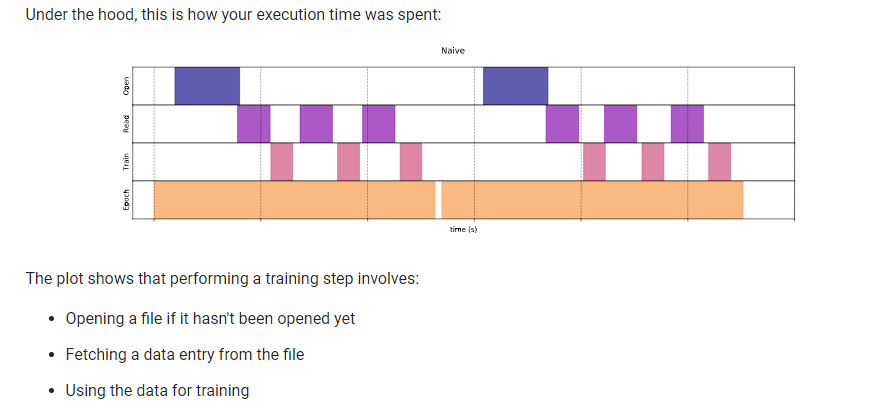

we used autotune for better performance it allow us to load and fetch the data during the idle cpu time in training 

In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

tensorflow allows us to use preprocessing step as a layer during the training, this layer applys transformations to the training images, such as rotation and flipping. This helps expose the model to different aspects of the training data and reduce overfitting. : [source](https://www.tensorflow.org/tutorials/images/data_augmentation) 

In [61]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [62]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # using pretrained mode mobile net's preprocessing layer 

In [63]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # normally we apply 1/255 to scale the intensity of the pixel to a value form 0 to 1 , here the values would be from 0 to 2 

In [64]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # using pretrained weights 

9420800/9406464 [==============================] - 0s 0us/step


In [65]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [66]:
base_model.trainable = False # freezing the pretrained model's  

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [67]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [68]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [69]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [84]:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
base_learning_rate = 0.0001
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])



In [86]:
initial_epochs = 5

loss0, accuracy0,f1,perc,recall = model.evaluate(validation_dataset)

7/7 [==============================] - 14s 32ms/step - loss: 0.4771 - acc: 0.9691 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1: {:.2f}".format(f1))
print("initial percision: {:.2f}".format(perc))
print("initial recall: {:.2f}".format(recall))

In [89]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
25/25 [==============================] - 71s 2s/step - loss: 0.4491 - acc: 0.9709 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3976 - val_acc: 0.9742 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
25/25 [==============================] - 66s 2s/step - loss: 0.4485 - acc: 0.9709 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4771 - val_acc: 0.9691 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
25/25 [==============================] - 66s 2s/step - loss: 0.4485 - acc: 0.9709 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4771 - val_acc: 0.9691 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
25/25 [==============================] - 77s 2s/step - loss: 0.4485 - acc: 0.9709 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_los

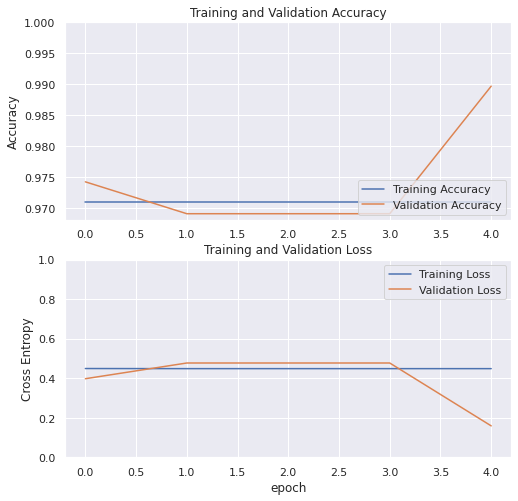

In [93]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# prediction and classification report

In [ ]:
predicted_categories = np.argmax(y_pred, axis = 1)
predicted_categories[:2]
true_categories = tf.concat([y for x, y in validation_generator], axis = 0).numpy() # convert to np array

true_categories[:2]
true_categories_argmax = np.argmax(true_categories, axis = 1)
print(classification_report(true_categories_argmax, predicted_categories))


analysis on creators 

In [ ]:
creator_price_data = All_data.groupby(by=['creator']).sum()

In [ ]:
creator_price_data

,price,likes,nsfw,tokens,year,rights,royalty
creator,,,,,,,
a-u-m,25400.0,2,0,3,6034,5,0
a1-shroom-spores,588.0,4,0,164,30300,15,0
aagabriel,42000.0,0,0,1,2020,3,0
adamfryda-art,3350.0,2,0,66,18167,9,0
adikhen,12.0,0,0,2,2021,3,0
...,...,...,...,...,...,...,...
zord189,155.0,2,0,10,8083,8,0
zullyscott,700.0,0,0,33,32325,28,0
zuly63,592.0,2,0,34,22227,17,0


In [ ]:
creator_price_data.sort_values(by='price', ascending=False)

,price,likes,nsfw,tokens,year,rights,royalty
creator,,,,,,,
derflow,2.744850e+06,1,0,1,1985,1,0
xbrucethegoosex,2.500478e+06,2,0,20,10100,5,0
blakestorieart,9.234134e+05,2,0,202,30279,33,0
doze,2.669806e+05,29,2,346,187877,145,0
masakaano,1.801120e+05,2,0,2,4042,4,0
...,...,...,...,...,...,...,...
rabitibike112,1.000000e+01,0,0,5,2021,3,0
polarmystro,1.000000e+01,0,0,3,2021,3,0
cryptomasterg,9.000000e+00,3,0,5,2021,3,0


# obj detection feature extraction 

In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.2
The following GPU devices are available: /device:GPU:0


In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# containing features 

In [ ]:
#https://stackoverflow.com/questions/69610530/print-objects-from-tensorflow-object-detection-api

# end of tf_api

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

this functions uses the detector (mobilenet) to extract the objects that exist 

In [ ]:
def class_detector(detector, path): # input (od model , path to image )
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  classes_detected =  set(result["detection_class_entities"]) # stores only unique classes detected 
  return classes_detected
 

# change the path to drive

a function to replace the old path to the new path in the drive 

In [ ]:
def replace_path(path, frm, to): # input (path , old extension that we want to remove , replacement path to add before )
    pre, match, post = path.rpartition(frm)
    return ''.join((to if match else pre, match, post))

In [ ]:
nsfw_df = All_data[(All_data["type"] == 'PHOTO') ]

In [ ]:
nsfw_df # data frame of photos only 

In [ ]:
NSFW_path_mod = nsfw_df[(nsfw_df["type"] == 'PHOTO')  & ( nsfw_df["nsfw"]== True)].pop('path')

In [ ]:
SFW_path_mod = nsfw_df[(nsfw_df["type"] == 'PHOTO')  & ( nsfw_df["nsfw"]== False)].pop('path')

apply the replace function to all the nsfw images

In [ ]:
for count, img in enumerate(NSFW_path_mod): 
  id = nsfw_df[nsfw_df['path']==img].index.values
  nsfw_df['path'][id] = replace_path(img, img[15:],'/content/drive/MyDrive/da_project_data_split/nsfw_images')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)


apply the replace function to all the sfw images

In [ ]:
for count, img in enumerate(SFW_path_mod):
  id = nsfw_df[nsfw_df['path']==img].index.values
  nsfw_df['path'][id] = replace_path(img, img[15:],'/content/drive/MyDrive/da_project_data_split/image')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)


In [ ]:
new_NSFW_path_mod = nsfw_df[(nsfw_df["type"] == 'PHOTO')  & ( nsfw_df["nsfw"]== True)].pop('path')

In [ ]:
NSFW_path_mod # the old path of the images, this is not where our data is split we need to change the path 

2       ./dataset/image/QmaifAjZTJd8jTxNrwSoGWmFpbPYcs...
26      ./dataset/image/QmeddHYx6UDmTRRLDdCYmzVK4VjRGQ...
28      ./dataset/image/QmaM1zTWoiYwT5L4BNcaaRnB56ueai...
33      ./dataset/image/QmbQASW3MxD8AzDNaPCFunKJ8rVSSQ...
69      ./dataset/image/QmVyVXEKrwhTBo6QsvPqC4vSK5THwt...
                              ...                        
3843    ./dataset/image/Qmazun61wXRfPjHDwwE7pDtRSuekeH...
3880    ./dataset/image/QmVDXWPYxQ97Z9vB6hEoTbWKgzrS1g...
4096    ./dataset/image/QmQ9BRvwJyysQDuEqsGNEfcA7na93v...
4145    ./dataset/image/QmQ9BRvwJyysQDuEqsGNEfcA7na93v...
4160    ./dataset/image/QmXjhH7XLddZdssnSnj9CxYt12WRqm...
Name: path, Length: 118, dtype: object

In [ ]:
new_NSFW_path_mod # the new paths 

2       /content/drive/MyDrive/da_project_data_split/n...
26      /content/drive/MyDrive/da_project_data_split/n...
28      /content/drive/MyDrive/da_project_data_split/n...
33      /content/drive/MyDrive/da_project_data_split/n...
69      /content/drive/MyDrive/da_project_data_split/n...
                              ...                        
3843    /content/drive/MyDrive/da_project_data_split/n...
3880    /content/drive/MyDrive/da_project_data_split/n...
4096    /content/drive/MyDrive/da_project_data_split/n...
4145    /content/drive/MyDrive/da_project_data_split/n...
4160    /content/drive/MyDrive/da_project_data_split/n...
Name: path, Length: 118, dtype: object

running the detector model on the new paths 

In [ ]:
classes = [] # create a list that appends all the objects 
for image in nsfw_df['path'][:50]:
    classes_detected = []
    try:
      classes_detected = class_detector(detector,image) # 
    except:
      classes.append(pd.NA) # if file is corrubted skip 
      continue
    tag_index = nsfw_df[nsfw_df['path']==image].index.values
    classes.append(classes_detected)
    print(tag_index) 

[2]
[3]
[14]
[15]
[25]
[26]
[27]
[28]
[30]
[31]
[34]
[35]
[36]
[37]
[40]
[41]
[45]
[52]
[53]
[59]
[65]
[68]


In [ ]:
sample_df = nsfw_df[:50]

In [ ]:
sample_df.insert(2, "tags", classes)
# insert the new column "tags"

In [ ]:
sample_df.drop(columns= ['creator', 'art_series', 'price', 'symbol', 'type', 'likes', 'royalty', 'cid',  'path' ], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)# more options can be specified also
sample_df[19:29]

,title,name,tags,nsfw,tokens,year,rights
30,Mística,Místicismo,"{b'Person', b'Human face', b'Fashion accessory...",False,1,2020,3
31,CryptoArts,Satan Lover,"{b'Person', b'Human face', b'Man', b'Clothing'...",False,5,2021,3
32,Drawings,Ancient MU,<NA>,False,3,2013,1
33,Static Art,1,<NA>,True,3,2021,1
34,Simplicity,Grow,"{b'Person', b'Human face', b'Balloon', b'Toy',...",False,3,2020,1
35,CryptoArts,The Snail In the Rain,"{b'Watercraft', b'Poster', b'Boat', b'Vehicle'...",False,3,2021,3
36,About Heraklion,"Reality & Dream in front of Koules, Heraklion ...","{b'Box', b'Person', b'Human face', b'Toy', b'C...",False,1,2021,1
37,white owl,white owl,"{b'Eagle', b'Human face', b'Falcon', b'Human m...",False,2,2020,1
40,CryptoArts,Cuts and Wounds,"{b'Window', b'Person', b'Stairs', b'Man', b'Cl...",False,3,2021,3
41,CryptoArts,Marilyn Monroe - The Zombie,"{b'Person', b'Human face', b'Fashion accessory...",False,3,2021,3


In [ ]:
nsfw_df[19:29]

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
30,Mística,Místicismo,alfonsoj,alfonsoj_mistica_misticismo,50.0,SWAP.HIVE,PHOTO,0,False,1,2020,3,0,QmQ9zjvq63ytyXmRhmEX28eGK2DqmLvuekPyJqh36kkV9e,/content/drive/MyDrive/da_project_data_split/i...
31,CryptoArts,Satan Lover,xxxthorxxx,xxxthorxxx_cryptoarts_satan-lover,50.0,SWAP.HIVE,PHOTO,1,False,5,2021,3,0,QmU3yyccbWK2xRhBqnaUyhTKZZ1YxPrALnJGbsjeDDF9JD,/content/drive/MyDrive/da_project_data_split/i...
32,Drawings,Ancient MU,trayan,trayan_drawings_ancient-mu,9.0,SWAP.HIVE,PHOTO,0,False,3,2013,1,0,QmRMHWsY536sBj3piLN8qndyb7Xae62goktDrXBMuXb1nZ,/content/drive/MyDrive/da_project_data_split/i...
33,Static Art,1,tygertyger,tygertyger_static-art_1,111.0,SWAP.HIVE,PHOTO,0,True,3,2021,1,0,QmbQASW3MxD8AzDNaPCFunKJ8rVSSQ4sNPMbWzHfoAQhRF,/content/drive/MyDrive/da_project_data_split/n...
34,Simplicity,Grow,leslieebano,leslieebano_simplicity_grow,10.0,SWAP.HIVE,PHOTO,0,False,3,2020,1,0,QmXwPqsBZ31Sc1nejfGMGU1A3Sf6HPhVpX2h66TtqF63M1,/content/drive/MyDrive/da_project_data_split/i...
35,CryptoArts,The Snail In the Rain,xxxthorxxx,xxxthorxxx_cryptoarts_the-snail-in-the-rain,30.0,SWAP.HIVE,PHOTO,0,False,3,2021,3,0,QmducSs5RFtwasBnjx8p1e4H4Uw9mYooAVtBLQoSMJyrTk,/content/drive/MyDrive/da_project_data_split/i...
36,About Heraklion,"Reality & Dream in front of Koules, Heraklion ...",katerinaramm,katerinaramm_about-heraklion_reality-dream-in-...,80.0,SWAP.HIVE,PHOTO,0,False,1,2021,1,0,QmX2CcqS6b5yeUuYqePApb9dzVbJVJKZ1XEeKnsh6Ltjwa,/content/drive/MyDrive/da_project_data_split/i...
37,white owl,white owl,elenasteem,elenasteem_white-owl_white-owl,50.0,SWAP.HIVE,PHOTO,0,False,2,2020,1,0,QmZ87ZfVxBB3D1myFKzQxrHv9sJf3bKbuZf2M1TWJwjDeL,/content/drive/MyDrive/da_project_data_split/i...
40,CryptoArts,Cuts and Wounds,xxxthorxxx,xxxthorxxx_cryptoarts_cuts-and-wounds,20.0,SWAP.HIVE,PHOTO,0,False,3,2021,3,0,QmcoYgLiUry31B76ijZwUrUr9dnXCcjafiMvTYa8HGzUoG,/content/drive/MyDrive/da_project_data_split/i...
41,CryptoArts,Marilyn Monroe - The Zombie,xxxthorxxx,xxxthorxxx_cryptoarts_marilyn-monroe-the-zombie,30.0,SWAP.HIVE,PHOTO,2,False,3,2021,3,0,QmQQsnwZmZ66vXdkUPRTxKQ5HZoj1LpPW4U4dHi5xMvduU,/content/drive/MyDrive/da_project_data_split/i...


the nans are because some of the images got removed because it's corrupted 

# running boudery box detection : 
[reference](https://www.tensorflow.org/hub/tutorials/object_detection) : tensorflow

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [ ]:
indexed_img.drop(columns=['index'],inplace=True)

In [ ]:
obj_data = []

In [ ]:
indexed_img[:10]

In [ ]:
for index in indexed_img.index[0:2]:
  val = indexed_img['path'].values[index]
  D_=run_detector(detector, val)
  obj_data.append(D_)



In [ ]:
X = run_detector(detector, '/content/drive/MyDrive/da_project_data_split/nsfw_images/QmNT4qptFt32sieTLRDVWkBNgeE5p5X3rPkC5njiroBfuk.png')

In [ ]:
X

{b'Clothing',
 b'Fashion accessory',
 b'Flower',
 b'Footwear',
 b'Human arm',
 b'Human eye',
 b'Human face',
 b'Human hair',
 b'Human head',
 b'Human mouth',
 b'Person',
 b'Woman'}

In [ ]:
run_detector(detector, All_img_path[30])

Found 100 objects.
Inference time:  58.88211393356323


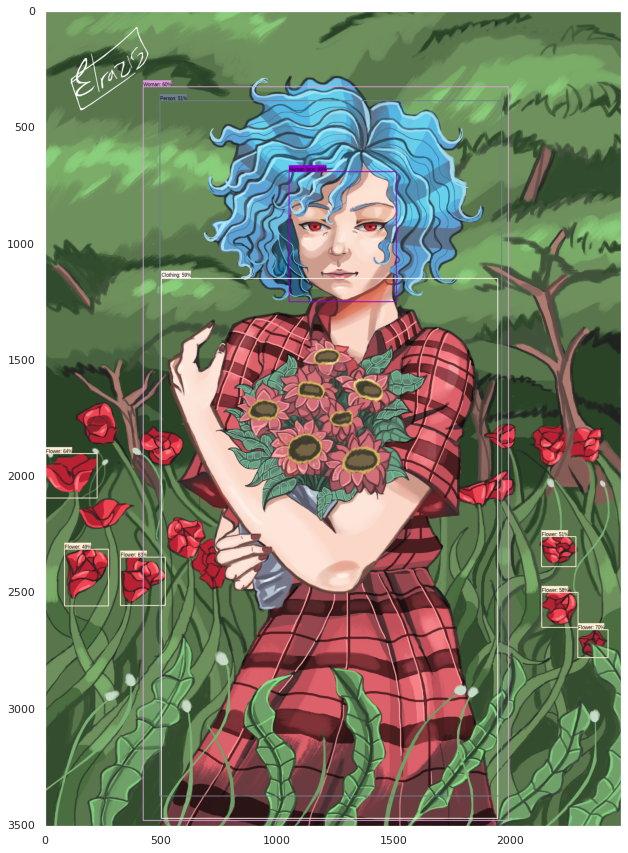

In [ ]:
run_detector(detector, All_img_path[266])

2002 has nudity and not classified as NSFW

9 is also missclassified


246 painter 

266 beauty 

1494 troller

